### USING SMOTE

* https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
* https://github.com/benai9916/Handle-imbalanced-data/blob/master/handle-imbalance-data.ipynb

##### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from collections import Counter

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
%matplotlib inline

### Get Data

In [2]:
xls = pd.ExcelFile(r'C:\Users\RONALD\Desktop\Internships\KPMG\module 2\KPMG_updated_data.xlsx')
xsac_data = pd.read_excel(xls,"Transactions")
custdemo_data = pd.read_excel(xls,"CustDemo")
newcustlist_data = pd.read_excel(xls,"NewCustList")

### Define Functions

In [3]:
def treat_missing_values_num(col_list, data):
    
    for i in col_list:
        col_name = i
        print('Independent Variable: ',col_name)
        print('Check if there are any missing value in variable',col_name,': ')
        if (data[col_name].isnull().any().any() == True):
            print('No. of Observations with missing value: ', data[col_name].isnull().sum(axis=0))
            # Replacing missing values with Median
            data[col_name].fillna(data[col_name].median(), inplace=True)
            print('After treating the missing values')
            print(data[col_name].isnull().sum(axis=0))
            print('')
        else:
            print('No missing values found in ',col_name)
            print('')
   

In [4]:
def treat_missing_values_cat(cat_col_list, data):
    
    for i in cat_col_list:
        col_name = i
        print('Independent Variable: ',col_name)
        print('Check if there are any missing value in variable',col_name,': ')
        if (data[col_name].isnull().any().any() == True):
            print('No. of Observations with missing value: ', data[col_name].isnull().sum(axis=0))
            # Replacing missing values with Mode
            data[col_name].fillna(data[col_name].mode()[0], inplace=True)
            print('After treating the missing values')
            print('No. of Observations with missing value: ', data[col_name].isnull().sum(axis=0))
            print('')
        else:
            print('No missing values found in ',col_name)
            print('')

for i in range(train_num_cols.shape[1]):
    
    col_name = train_num_cols.columns[i]
    print("-------#######-------", col_name, "------######------")
    
    ax = sns.boxplot(x = train_num_cols.columns[i], data = train_num_cols)
    plt.show()
    sns.distplot(train_num_cols[col_name], bins=15) 
    plt.show()
    
    q1 = train_num_cols[col_name].quantile(0.25)
    q2 = train_num_cols[col_name].quantile(0.50)
    q3 = train_num_cols[col_name].quantile(0.75)
    iqr = q3 - q1
    LL = q1 - (1.5*iqr)
    UL = q3 + (1.5*iqr)
    print('Q1: ', q1)
    print('Q2: ', q2)
    print('Q3: ', q3)
    print('IQR: ', iqr)
    print('Lower Level: ', LL)
    print('Upper Level: ', UL)     
    print('     ')

#### Existing customer info

In [5]:
custdemo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

In [6]:
custdemo_data.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,state,address,postcode,country,property_valuation,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,NSW,060 Morning Avenue,2016,Australia,10,Family,Own,Row or Terrace House,Yes,Y
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,...,NSW,6 Meadow Vale Court,2153,Australia,10,Single,Own,Apartment,Yes,Y
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,...,NSW,070 Holy Avenue,2519,Australia,6,Single,Rent,Apartment,Yes,Y
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,...,QLD,0 Holy Cross Court,4211,Australia,9,Single,Rent,Apartment,Yes,Y
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,...,NSW,17979 Del Mar Point,2448,Australia,4,Family,Own,Separate,Yes,Y


In [7]:
custdemo_data.describe()

,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation
count,4000.000000,4000.000000,3913.000000,4000.000000,4000.000000
mean,2000.500000,48.890000,10.657041,2985.127500,7.514000
std,1154.844867,28.715005,5.660146,844.768574,2.824234
min,1.000000,0.000000,1.000000,2000.000000,1.000000
25%,1000.750000,24.000000,6.000000,2200.000000,6.000000
50%,2000.500000,48.000000,11.000000,2768.000000,8.000000
75%,3000.250000,73.000000,15.000000,3750.000000,10.000000
max,4000.000000,99.000000,22.000000,4883.000000,12.000000


In [8]:
custdemo_data.describe(include=np.object)

,first_name,last_name,gender,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,state,address,country,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status
count,4000,3875,4000,3494,3344,4000,4000,3698,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,3139,3725,6,195,9,3,2,90,2,3,3997,1,3,3,4,2,2
top,Tobe,Ramsdell,Female,Business Systems Development Analyst,Manufacturing,Mass Customer,N,100,Yes,NSW,3 Talisman Place,Australia,Family,Own,Apartment,Yes,Y
freq,5,3,2037,45,799,2000,3998,113,2024,2142,2,4000,2501,2258,1744,3816,3493


In [9]:
cd = custdemo_data.drop(['household_composition','household_type','dwelling_structure','have_internet_access','xsacn_status'], axis=1)
cd.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,state,address,postcode,country,property_valuation
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,NSW,060 Morning Avenue,2016,Australia,10
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,NSW,6 Meadow Vale Court,2153,Australia,10
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0,NSW,070 Holy Avenue,2519,Australia,6
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,QLD,0 Holy Cross Court,4211,Australia,9
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,NSW,17979 Del Mar Point,2448,Australia,4


In [10]:
cd.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'state', 'address', 'postcode',
       'country', 'property_valuation'],
      dtype='object')

In [11]:
cd.describe(include=np.object)

,first_name,last_name,gender,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,state,address,country
count,4000,3875,4000,3494,3344,4000,4000,3698,4000,4000,4000,4000
unique,3139,3725,6,195,9,3,2,90,2,3,3997,1
top,Tobe,Ramsdell,Female,Business Systems Development Analyst,Manufacturing,Mass Customer,N,100,Yes,NSW,3 Talisman Place,Australia
freq,5,3,2037,45,799,2000,3998,113,2024,2142,2,4000


#### Check if data is imbalanced

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [12]:
custdemo_data['xsacn_status'].value_counts()

Y    3493
N     507
Name: xsacn_status, dtype: int64

interested = custdemo_data[custdemo_data.xsacn_status == 'Y']
not_interested = custdemo_data[custdemo_data.xsacn_status == 'N']

print(interested.shape)
print(not_interested.shape)

#### Undersampling

interested_sample = interested.sample(n=507)
interested_sample.shape

#### Combine the data

cust_data = pd.concat([interested_sample, not_interested], axis=0) #### adding row-wise
cust_data.head()

cust_data.shape

cust_data.head(50)

#### New Customer list

In [13]:
newcustlist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            1000 non-null   object        
 6   job_industry_category                1000 non-null   object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

newcustlist_data.head()

#### Transaction info of existing customers

In [14]:
xsac_data.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


xsac_cust_id = []
xsac_cust_id = xsac_data['customer_id']
xsac_cust_id

## Lets see: Customer Demographic Data

In [15]:
custdemo_data.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'state', 'address', 'postcode',
       'country', 'property_valuation', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'xsacn_status'],
      dtype='object')

In [16]:
custdemo_data.describe()

,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation
count,4000.000000,4000.000000,3913.000000,4000.000000,4000.000000
mean,2000.500000,48.890000,10.657041,2985.127500,7.514000
std,1154.844867,28.715005,5.660146,844.768574,2.824234
min,1.000000,0.000000,1.000000,2000.000000,1.000000
25%,1000.750000,24.000000,6.000000,2200.000000,6.000000
50%,2000.500000,48.000000,11.000000,2768.000000,8.000000
75%,3000.250000,73.000000,15.000000,3750.000000,10.000000
max,4000.000000,99.000000,22.000000,4883.000000,12.000000


    tenure has missing values.

In [17]:
custdemo_data.describe(include='object')

,first_name,last_name,gender,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,state,address,country,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status
count,4000,3875,4000,3494,3344,4000,4000,3698,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,3139,3725,6,195,9,3,2,90,2,3,3997,1,3,3,4,2,2
top,Tobe,Ramsdell,Female,Business Systems Development Analyst,Manufacturing,Mass Customer,N,100,Yes,NSW,3 Talisman Place,Australia,Family,Own,Apartment,Yes,Y
freq,5,3,2037,45,799,2000,3998,113,2024,2142,2,4000,2501,2258,1744,3816,3493


    Missing values in column-
    last_namek, job_title, job_industry_category,default,

##### Check for duplicate rows

In [18]:
duplicate_custdemo = custdemo_data[custdemo_data.duplicated(['customer_id'])]
print("Duplicate Rows :")

duplicate_custdemo

Duplicate Rows :


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,state,address,postcode,country,property_valuation,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status


    Inference: No duplicate records

### For test data

### Data Cleaning and Formatting

### For training data

#### 1. Data Formatting
* drop fname, lname, default, cust_id, address, DOB(after getting age from DOB)
* calculate age column from dob
* fill missing values in columns- DOB, job_title, job_industry_category, tenure.
* Missing values of DOB/age - by taking median age
* Add a new columns: xsac, which signifies  if the customer has made any transactions

Numeric Columns: No formatting needed here.

### For Test data

#### Categorical Columns: (Train Data)

#### Column: Gender

In [19]:
custdemo_data['gender'].value_counts()

Female    2037
Male      1872
U           88
Femal        1
M            1
F            1
Name: gender, dtype: int64

In [20]:
custdemo_data['gender_updated'] = custdemo_data['gender']

In [21]:
for row in custdemo_data.index:
    if ((custdemo_data['gender_updated'][row] == 'Femal') or (custdemo_data['gender_updated'][row] == 'F')):
        val2 = 'Female'
        custdemo_data['gender_updated'][row] = val2
              
    elif ((custdemo_data['gender_updated'][row] == 'M') or (custdemo_data['gender_updated'][row] == 'U')):
        val2 = 'Male'
        custdemo_data['gender_updated'][row] = val2
    
    else:
        print('Alright!')
    

<ipython-input-21-57bb5076cdb3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  custdemo_data['gender_updated'][row] = val2
<ipython-input-21-57bb5076cdb3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  custdemo_data['gender_updated'][row] = val2


Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
A

Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
A

Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
A

Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
Alright!
A

In [22]:
custdemo_data['gender_updated'].value_counts()

Female    2039
Male      1961
Name: gender_updated, dtype: int64

In [23]:
custdemo_data.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,address,postcode,country,property_valuation,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status,gender_updated
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,060 Morning Avenue,2016,Australia,10,Family,Own,Row or Terrace House,Yes,Y,Female
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,...,6 Meadow Vale Court,2153,Australia,10,Single,Own,Apartment,Yes,Y,Male
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,...,070 Holy Avenue,2519,Australia,6,Single,Rent,Apartment,Yes,Y,Male
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,...,0 Holy Cross Court,4211,Australia,9,Single,Rent,Apartment,Yes,Y,Male
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,...,17979 Del Mar Point,2448,Australia,4,Family,Own,Separate,Yes,Y,Female


custdemo_data['gender_updated'].value_counts().plot.bar(figsize=(8,8),title='Updated Gender')

    Note:
    We will remove column gender and use column gender_updated

#### Column: DOB
We will calculate age of the customers from DOB column

In [24]:
def age(birthdate):
    today = date.today()
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

In [25]:
custdemo_data['age'] = custdemo_data['customer_id']  ### To create a new column Age in the existing dataframe

In [26]:
custdemo_data.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'state', 'address', 'postcode',
       'country', 'property_valuation', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'xsacn_status', 'gender_updated', 'age'],
      dtype='object')

In [27]:
### calculating age of each customer and updating the value in the column age.
for row in custdemo_data.index:
    val = age(custdemo_data["DOB"][row])
    custdemo_data['age'][row] = val
    #print(val)

<ipython-input-27-15dc4f587089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  custdemo_data['age'][row] = val
C:\Users\RONALD\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
custdemo_data.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,postcode,country,property_valuation,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status,gender_updated,age
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,...,2016,Australia,10,Family,Own,Row or Terrace House,Yes,Y,Female,68.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,...,2153,Australia,10,Single,Own,Apartment,Yes,Y,Male,41.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,...,2519,Australia,6,Single,Rent,Apartment,Yes,Y,Male,68.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,...,4211,Australia,9,Single,Rent,Apartment,Yes,Y,Male,60.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,...,2448,Australia,4,Family,Own,Separate,Yes,Y,Female,44.0


In [29]:
custdemo_data.describe()  #### to chec for maximum age

,customer_id,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,age
count,4000.000000,4000.000000,3913.000000,4000.000000,4000.000000,3913.000000
mean,2000.500000,48.890000,10.657041,2985.127500,7.514000,44.235625
std,1154.844867,28.715005,5.660146,844.768574,2.824234,12.799987
min,1.000000,0.000000,1.000000,2000.000000,1.000000,20.000000
25%,1000.750000,24.000000,6.000000,2200.000000,6.000000,35.000000
50%,2000.500000,48.000000,11.000000,2768.000000,8.000000,44.000000
75%,3000.250000,73.000000,15.000000,3750.000000,10.000000,54.000000
max,4000.000000,99.000000,22.000000,4883.000000,12.000000,178.000000


### For test Data

#### For Visualization
We are saving a copy of this dataset to prepare for data visualization

df = custdemo_data.copy()
df.head()

df.columns

#df = df.drop(['first_name','last_name','gender','DOB','address','country','default','postcode'], axis=1)
df.head()

df.isnull().sum()

df_num = df[df.select_dtypes(include = [np.number]).columns.tolist()]
df_cat = df[df.select_dtypes(exclude = [np.number]).columns.tolist()]

df_num.columns

num_cols = ['past_3_years_bike_related_purchases', 'tenure', 'property_valuation', 'age']

df_cat.columns

treat_missing_values_num(num_cols, df)

df_cat.isnull().sum(axis=0)

cat_cols = ['job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'state', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'gender_updated']

treat_missing_values_cat(cat_cols, df)

df.isnull().sum(axis=0)

df.to_csv(r'C:\Users\RONALD\Desktop\Internships\KPMG\module 2\updated_cust_data.csv')

In [30]:
custdemo_data.loc[custdemo_data['age']>80]  ### to retrieve records above 80 years

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,postcode,country,property_valuation,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status,gender_updated,age
33,34,Jephthah,Bachmann,U,59,1843-12-21,Legal Assistant,IT,Affluent Customer,N,...,4005,Australia,8,Single,Rent,Apartment,Yes,Y,Male,178.0
719,720,Darrel,Canet,Male,67,1931-10-23,Recruiting Manager,Retail,Affluent Customer,N,...,2026,Australia,10,Family,Own,Separate,Yes,Y,Male,90.0
1091,1092,Katlin,Creddon,Female,56,1935-08-22,VP Quality Control,Retail,Mass Customer,N,...,3337,Australia,3,Family,Mortgage,Apartment,No,Y,Female,86.0
3409,3410,Merrili,Brittin,Female,93,1940-09-22,NaN,Property,Mass Customer,N,...,2049,Australia,10,Family,Mortgage,Apartment,Yes,Y,Female,81.0


pred

### Drop unnecessary columns

#### Train Data

In [31]:
train_data = custdemo_data.drop(['customer_id','first_name','last_name','gender','DOB','address','country','default','postcode'], axis=1)
train_data.head()

,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,state,property_valuation,household_composition,household_type,dwelling_structure,have_internet_access,xsacn_status,gender_updated,age
0,93,Executive Secretary,Health,Mass Customer,N,Yes,11.0,NSW,10,Family,Own,Row or Terrace House,Yes,Y,Female,68.0
1,81,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,NSW,10,Single,Own,Apartment,Yes,Y,Male,41.0
2,61,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,NSW,6,Single,Rent,Apartment,Yes,Y,Male,68.0
3,33,NaN,IT,Mass Customer,N,No,7.0,QLD,9,Single,Rent,Apartment,Yes,Y,Male,60.0
4,56,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,NSW,4,Family,Own,Separate,Yes,Y,Female,44.0


In [32]:
train_data.columns

Index(['past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'state', 'property_valuation',
       'household_composition', 'household_type', 'dwelling_structure',
       'have_internet_access', 'xsacn_status', 'gender_updated', 'age'],
      dtype='object')

In [33]:
train_data.isnull().sum(axis=0)

past_3_years_bike_related_purchases      0
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                  87
state                                    0
property_valuation                       0
household_composition                    0
household_type                           0
dwelling_structure                       0
have_internet_access                     0
xsacn_status                             0
gender_updated                           0
age                                     87
dtype: int64

#### Test Data

In [34]:
train_data.columns

Index(['past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'state', 'property_valuation',
       'household_composition', 'household_type', 'dwelling_structure',
       'have_internet_access', 'xsacn_status', 'gender_updated', 'age'],
      dtype='object')

In [35]:
train_col_name = ['past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'state', 'property_valuation',
       'household_composition', 'household_type', 'dwelling_structure',
       'have_internet_access', 'gender_updated', 'age', 'xsacn_status']

In [36]:
train_data = train_data.reindex(columns=train_col_name)

In [37]:
train_data.columns

Index(['past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'state', 'property_valuation',
       'household_composition', 'household_type', 'dwelling_structure',
       'have_internet_access', 'gender_updated', 'age', 'xsacn_status'],
      dtype='object')

In [38]:
train_data.head()

,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,state,property_valuation,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,age,xsacn_status
0,93,Executive Secretary,Health,Mass Customer,N,Yes,11.0,NSW,10,Family,Own,Row or Terrace House,Yes,Female,68.0,Y
1,81,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,NSW,10,Single,Own,Apartment,Yes,Male,41.0,Y
2,61,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,NSW,6,Single,Rent,Apartment,Yes,Male,68.0,Y
3,33,NaN,IT,Mass Customer,N,No,7.0,QLD,9,Single,Rent,Apartment,Yes,Male,60.0,Y
4,56,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,NSW,4,Family,Own,Separate,Yes,Female,44.0,Y


### Splitting data into Numeric and Categorical Dataset (For Train Data):

In [39]:
train_num_data = train_data[train_data.select_dtypes(include = [np.number]).columns.tolist()]
train_cat_data = train_data[train_data.select_dtypes(exclude = [np.number]).columns.tolist()]

In [40]:
train_num_data.columns

Index(['past_3_years_bike_related_purchases', 'tenure', 'property_valuation',
       'age'],
      dtype='object')

In [41]:
train_cat_data.columns

Index(['job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'state', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'gender_updated', 'xsacn_status'],
      dtype='object')

### Splitting data into Numeric and Categorical Dataset (For Test Data):

### Missing Value Identification & Treatment: (Train Data)

#### Numerical Data

In [42]:
train_num_data.isnull().sum(axis=0)

past_3_years_bike_related_purchases     0
tenure                                 87
property_valuation                      0
age                                    87
dtype: int64

In [43]:
col_list=['tenure','age']

In [44]:
treat_missing_values_num(col_list, train_num_data)

Independent Variable:  tenure
Check if there are any missing value in variable tenure : 
No. of Observations with missing value:  87
After treating the missing values
0

Independent Variable:  age
Check if there are any missing value in variable age : 
No. of Observations with missing value:  87
After treating the missing values
0



C:\Users\RONALD\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [45]:
train_num_data.isnull().sum(axis=0)

past_3_years_bike_related_purchases    0
tenure                                 0
property_valuation                     0
age                                    0
dtype: int64

#### Categorical Data

In [46]:
train_cat_data.isnull().sum(axis=0)

job_title                506
job_industry_category    656
wealth_segment             0
deceased_indicator         0
owns_car                   0
state                      0
household_composition      0
household_type             0
dwelling_structure         0
have_internet_access       0
gender_updated             0
xsacn_status               0
dtype: int64

In [47]:
for i in range(train_cat_data.shape[1]):
    col_name = train_cat_data.columns[i]
    print('COLUMN NAME: ', col_name)
    print(train_cat_data[col_name].value_counts())
    print("================================")
    print(" ")

COLUMN NAME:  job_title
Business Systems Development Analyst    45
Tax Accountant                          44
Social Worker                           44
Internal Auditor                        42
Legal Assistant                         41
                                        ..
Database Administrator II                4
Research Assistant III                   3
Health Coach III                         3
Health Coach I                           3
Developer I                              1
Name: job_title, Length: 195, dtype: int64
 
COLUMN NAME:  job_industry_category
Manufacturing         799
Financial Services    774
Health                602
Retail                358
Property              267
IT                    223
Entertainment         136
Argiculture           113
Telecommunications     72
Name: job_industry_category, dtype: int64
 
COLUMN NAME:  wealth_segment
Mass Customer        2000
High Net Worth       1021
Affluent Customer     979
Name: wealth_segment, dtype: int64
 


In [48]:
cat_col_list=['job_title', 'job_industry_category']
cat_col_list

['job_title', 'job_industry_category']

In [49]:
treat_missing_values_cat(cat_col_list, train_cat_data)

Independent Variable:  job_title
Check if there are any missing value in variable job_title : 
No. of Observations with missing value:  506
After treating the missing values
No. of Observations with missing value:  0

Independent Variable:  job_industry_category
Check if there are any missing value in variable job_industry_category : 
No. of Observations with missing value:  656
After treating the missing values
No. of Observations with missing value:  0



In [50]:
train_cat_data.isnull().sum(axis=0)

job_title                0
job_industry_category    0
wealth_segment           0
deceased_indicator       0
owns_car                 0
state                    0
household_composition    0
household_type           0
dwelling_structure       0
have_internet_access     0
gender_updated           0
xsacn_status             0
dtype: int64

### Missing Value Identification & Treatment: (Test Data)

### Outlier Identification and Treatment : (Train Data)

-------#######------- past_3_years_bike_related_purchases ------######------


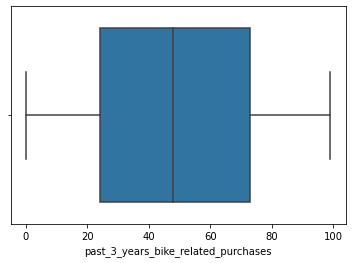

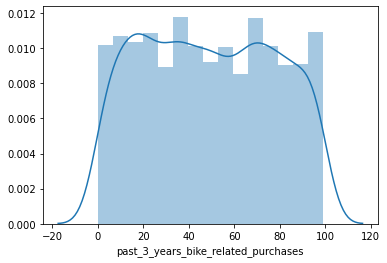

Q1:  24.0
Q2:  48.0
Q3:  73.0
IQR:  49.0
Lower Level:  -49.5
Upper Level:  146.5
     
-------#######------- tenure ------######------


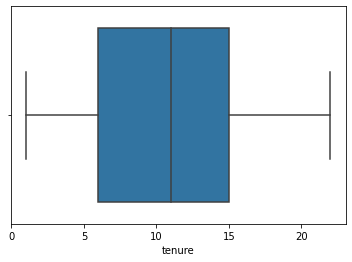

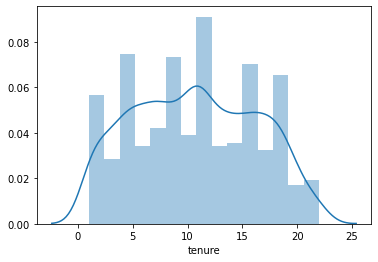

Q1:  6.0
Q2:  11.0
Q3:  15.0
IQR:  9.0
Lower Level:  -7.5
Upper Level:  28.5
     
-------#######------- property_valuation ------######------


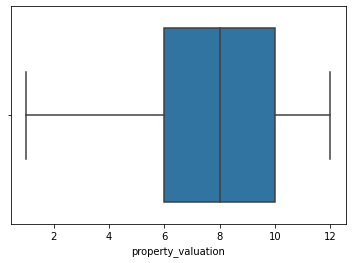

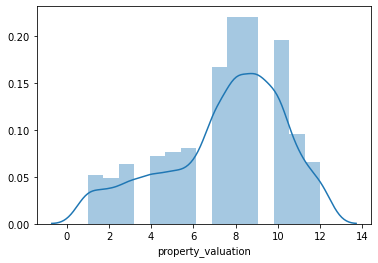

Q1:  6.0
Q2:  8.0
Q3:  10.0
IQR:  4.0
Lower Level:  0.0
Upper Level:  16.0
     
-------#######------- age ------######------


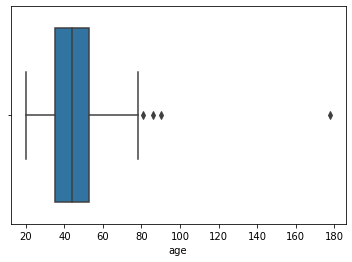

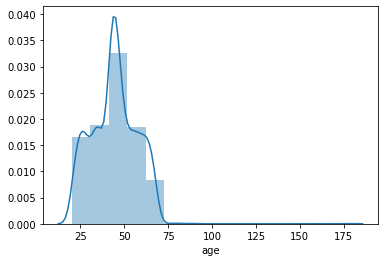

Q1:  35.0
Q2:  44.0
Q3:  53.0
IQR:  18.0
Lower Level:  8.0
Upper Level:  80.0
     


In [51]:
for i in range(train_num_data.shape[1]):
    
    col_name = train_num_data.columns[i]
    print("-------#######-------", col_name, "------######------")
    
    ax = sns.boxplot(x = train_num_data.columns[i], data = train_num_data)
    plt.show()
    sns.distplot(train_num_data[col_name], bins=15) 
    plt.show()
    
    q1 = train_num_data[col_name].quantile(0.25)
    q2 = train_num_data[col_name].quantile(0.50)
    q3 = train_num_data[col_name].quantile(0.75)
    iqr = q3 - q1
    LL = q1 - (1.5*iqr)
    UL = q3 + (1.5*iqr)
    print('Q1: ', q1)
    print('Q2: ', q2)
    print('Q3: ', q3)
    print('IQR: ', iqr)
    print('Lower Level: ', LL)
    print('Upper Level: ', UL)     
    print('     ')

* Note: For age column, we observe right skewed data. In order to balance this data, we will group these ages.

#### Convert age to age_group

In [52]:
train_num_data['age_group'] = train_num_data['age']

<ipython-input-52-865981067958>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num_data['age_group'] = train_num_data['age']


In [53]:
for row in train_num_data.index:
    if(train_num_data['age'][row] <= 20):
        status = 'Below 20'
        train_num_data['age_group'][row] = status
        #print(status)
        
    elif((train_num_data['age'][row] >= 21) and (train_num_data['age'][row] <= 30)):
        status = 'Between 21 and 30'
        train_num_data['age_group'][row] = status
        #print(status)
        
    elif((train_num_data['age'][row] >= 31) and (train_num_data['age'][row] <= 45)):
        status = 'Between 31 and 45'
        train_num_data['age_group'][row] = status
        #print(status)
        
    elif((train_num_data['age'][row] >=46) and (train_num_data['age'][row] <= 60)):
        status = 'Between 46 and 60'
        train_num_data['age_group'][row] = status
        
    else:
        status = 'Above 60'
        train_num_data['age_group'][row] = status
        #print(status)

<ipython-input-53-cc4a25d7457f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num_data['age_group'][row] = status
C:\Users\RONALD\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\RONALD\anaconda3\lib\site-packages\pandas\core\series.py:1024: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[key] = value
C:\Users\RONA

In [54]:
train_num_data.head()

,past_3_years_bike_related_purchases,tenure,property_valuation,age,age_group
0,93,11.0,10,68.0,Above 60
1,81,16.0,10,41.0,Between 31 and 45
2,61,15.0,6,68.0,Above 60
3,33,7.0,9,60.0,Between 46 and 60
4,56,8.0,4,44.0,Between 31 and 45


In [55]:
train_num_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   past_3_years_bike_related_purchases  4000 non-null   int64  
 1   tenure                               4000 non-null   float64
 2   property_valuation                   4000 non-null   int64  
 3   age                                  4000 non-null   float64
 4   age_group                            4000 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 156.4+ KB


### Adding the age_group column to categorical data.

In [56]:
train_cat_data['age_group'] = train_num_data['age_group']

<ipython-input-56-b1c9a116ef50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat_data['age_group'] = train_num_data['age_group']


In [57]:
train_cat_data.head()

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [58]:
train_cat_data.isnull().sum(axis=0)

job_title                0
job_industry_category    0
wealth_segment           0
deceased_indicator       0
owns_car                 0
state                    0
household_composition    0
household_type           0
dwelling_structure       0
have_internet_access     0
gender_updated           0
xsacn_status             0
age_group                0
dtype: int64

#### updating numeric column

In [59]:
updated_num_data = train_num_data.copy()

In [60]:
updated_num_data.head()

,past_3_years_bike_related_purchases,tenure,property_valuation,age,age_group
0,93,11.0,10,68.0,Above 60
1,81,16.0,10,41.0,Between 31 and 45
2,61,15.0,6,68.0,Above 60
3,33,7.0,9,60.0,Between 46 and 60
4,56,8.0,4,44.0,Between 31 and 45


In [61]:
updated_num_data = updated_num_data.drop(['age','age_group'], axis=1)
updated_num_data.head()

,past_3_years_bike_related_purchases,tenure,property_valuation
0,93,11.0,10
1,81,16.0,10
2,61,15.0,6
3,33,7.0,9
4,56,8.0,4


### Outlier Identification & Treatment - For test Data

### Categorical data (Train Data)

In [62]:
train_cat_data.head()

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [63]:
train_cat_data.describe(include=np.object)

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
count,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,195,9,3,2,2,3,3,3,4,2,2,2,5
top,Business Systems Development Analyst,Manufacturing,Mass Customer,N,Yes,NSW,Family,Own,Apartment,Yes,Female,Y,Between 31 and 45
freq,551,1455,2000,3998,2024,2142,2501,2258,1744,3816,2039,3493,1560


In [64]:
for i in range(train_cat_data.shape[1]):
    col_name = train_cat_data.columns[i]
    print('COLUMN NAME: ', col_name)
    print(train_cat_data[col_name].value_counts())
    print("================================")
    print(" ")

COLUMN NAME:  job_title
Business Systems Development Analyst    551
Tax Accountant                           44
Social Worker                            44
Internal Auditor                         42
Legal Assistant                          41
                                       ... 
Database Administrator II                 4
Research Assistant III                    3
Health Coach III                          3
Health Coach I                            3
Developer I                               1
Name: job_title, Length: 195, dtype: int64
 
COLUMN NAME:  job_industry_category
Manufacturing         1455
Financial Services     774
Health                 602
Retail                 358
Property               267
IT                     223
Entertainment          136
Argiculture            113
Telecommunications      72
Name: job_industry_category, dtype: int64
 
COLUMN NAME:  wealth_segment
Mass Customer        2000
High Net Worth       1021
Affluent Customer     979
Name: wealth_segm

#### Label  (Train Data)

from sklearn.preprocessing import LabelEncoder

#with_cat_cols_data['Employment_Length'] = with_cat_cols_data['Employment_Length'].apply(LabelEncoder().fit_transform)

train_cat_data.job_title=(LabelEncoder().fit_transform(train_cat_data.job_title))


In [65]:
train_cat_data.head()

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [66]:
train_cat_data.columns

Index(['job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'state', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'gender_updated', 'xsacn_status', 'age_group'],
      dtype='object')

### Other categorical columns 
##### For train Data

agegroup_mapper = {'Below 20': 0, 'Between 21 and 30': 1, 'Between 31 and 45': 2, 'Between 46 and 60': 3, 'Above 60': 4}
gender_mapper = {'Male': 0, 'Female': 1}
xsacn_mapper = {'N': 0, 'Y': 1}
internet_acc_mapper = {'No': 0, 'Yes':1}
hhtype_mapper = {'Own': 0, 'Rent': 1, 'Mortgage': 2}
dwell_mapper = {'Apartment': 0, 'Separate': 1, 'Row or Terrace House': 2, 'Other': 3}
hhcompo_mapper = {'Family': 0, 'Single': 1, 'Group': 2}
state_mapper = {'NSW': 0, 'VIC': 1, 'QLD': 2}
owns_mapper = {'No': 0, 'Yes': 1}
decind_mapper = {'N': 0, 'Y': 1}
wealth_mapper = {'Affluent Customer': 0, 'High Net Worth': 1, 'Mass Customer': 2}
jobindcat_mapper = {'Manufacturing': 0, 'Financial Services': 1, 'Health': 2, 'Retail': 3, 'Property': 4, 'IT': 5, 'Entertainment': 6,
                   'Argiculture': 7, 'Telecommunications': 8}

train_cat_data['age_group_scaled'] = train_cat_data['age_group'].replace(agegroup_mapper)
train_cat_data['gender_scaled'] = train_cat_data['gender_updated'].replace(gender_mapper)
train_cat_data['internet_access_scaled'] = train_cat_data['have_internet_access'].replace(internet_acc_mapper)
train_cat_data['household_type_scaled'] = train_cat_data['household_type'].replace(hhtype_mapper)
train_cat_data['dwelling_structure_scaled'] = train_cat_data['dwelling_structure'].replace(dwell_mapper)
train_cat_data['hh_composition_scaled'] = train_cat_data['household_composition'].replace(hhcompo_mapper)
train_cat_data['state_scaled'] = train_cat_data['state'].replace(state_mapper)
train_cat_data['own_car_scaled'] = train_cat_data['owns_car'].replace(owns_mapper)
train_cat_data['desceased_scaled'] = train_cat_data['deceased_indicator'].replace(decind_mapper)
train_cat_data['wealth_segment_scaled'] = train_cat_data['wealth_segment'].replace(wealth_mapper)
train_cat_data['jobindcat_scaled'] = train_cat_data['job_industry_category'].replace(jobindcat_mapper)
train_cat_data['xsacn_status_scaled'] = train_cat_data['xsacn_status'].replace(xsacn_mapper)

In [67]:
train_cat_data.head()

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [68]:
updated_cat_data = train_cat_data.copy()

In [69]:
updated_cat_data.columns

Index(['job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'state', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'gender_updated', 'xsacn_status', 'age_group'],
      dtype='object')

In [70]:
updated_cat_data.head()

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


updated_cat_data = updated_cat_data.drop(['job_industry_category','wealth_segment','deceased_indicator', 'owns_car', 'state', 
                                          'household_composition','household_type', 'dwelling_structure', 'have_internet_access',
                                          'xsacn_status', 'gender_updated', 'age_group'], axis=1)
updated_cat_data.columns

In [71]:
updated_cat_data.head()

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [72]:
updated_cat_data.columns

Index(['job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'state', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'gender_updated', 'xsacn_status', 'age_group'],
      dtype='object')

### Standardisation (For train data)

In [73]:
cols_train = []
cols_train=updated_num_data.columns
cols_train

Index(['past_3_years_bike_related_purchases', 'tenure', 'property_valuation'], dtype='object')

In [74]:
idx_train_num = updated_num_data.copy()

In [75]:
updated_num_data.head()

,past_3_years_bike_related_purchases,tenure,property_valuation
0,93,11.0,10
1,81,16.0,10
2,61,15.0,6
3,33,7.0,9
4,56,8.0,4


### Combining Numerical & Categorical data  (Train Data)

In [76]:
updated_cat_data.head()

,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [77]:
updated_num_data.head()

,past_3_years_bike_related_purchases,tenure,property_valuation
0,93,11.0,10
1,81,16.0,10
2,61,15.0,6
3,33,7.0,9
4,56,8.0,4


In [78]:
final_data = pd.concat([updated_num_data, updated_cat_data], axis=1)
final_data.head()

,past_3_years_bike_related_purchases,tenure,property_valuation,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,93,11.0,10,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,81,16.0,10,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,61,15.0,6,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,33,7.0,9,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,56,8.0,4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [79]:
final_data.isnull().sum(axis=0)

past_3_years_bike_related_purchases    0
tenure                                 0
property_valuation                     0
job_title                              0
job_industry_category                  0
wealth_segment                         0
deceased_indicator                     0
owns_car                               0
state                                  0
household_composition                  0
household_type                         0
dwelling_structure                     0
have_internet_access                   0
gender_updated                         0
xsacn_status                           0
age_group                              0
dtype: int64

In [80]:
final_data.columns

Index(['past_3_years_bike_related_purchases', 'tenure', 'property_valuation',
       'job_title', 'job_industry_category', 'wealth_segment',
       'deceased_indicator', 'owns_car', 'state', 'household_composition',
       'household_type', 'dwelling_structure', 'have_internet_access',
       'gender_updated', 'xsacn_status', 'age_group'],
      dtype='object')

### Data Partition

In [ ]:
#data_viz.to_csv(r'C:\Users\RONALD\Desktop\Internships\KPMG\module 3\output.csv') 

In [82]:
final_data.head()

,past_3_years_bike_related_purchases,tenure,property_valuation,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,state,household_composition,household_type,dwelling_structure,have_internet_access,gender_updated,xsacn_status,age_group
0,93,11.0,10,Executive Secretary,Health,Mass Customer,N,Yes,NSW,Family,Own,Row or Terrace House,Yes,Female,Y,Above 60
1,81,16.0,10,Administrative Officer,Financial Services,Mass Customer,N,Yes,NSW,Single,Own,Apartment,Yes,Male,Y,Between 31 and 45
2,61,15.0,6,Recruiting Manager,Property,Mass Customer,N,Yes,NSW,Single,Rent,Apartment,Yes,Male,Y,Above 60
3,33,7.0,9,Business Systems Development Analyst,IT,Mass Customer,N,No,QLD,Single,Rent,Apartment,Yes,Male,Y,Between 46 and 60
4,56,8.0,4,Senior Editor,Manufacturing,Affluent Customer,N,Yes,NSW,Family,Own,Separate,Yes,Female,Y,Between 31 and 45


In [83]:
final_data.isnull().sum(axis=0)

past_3_years_bike_related_purchases    0
tenure                                 0
property_valuation                     0
job_title                              0
job_industry_category                  0
wealth_segment                         0
deceased_indicator                     0
owns_car                               0
state                                  0
household_composition                  0
household_type                         0
dwelling_structure                     0
have_internet_access                   0
gender_updated                         0
xsacn_status                           0
age_group                              0
dtype: int64

In [84]:
final_data.to_csv(r'C:\Users\RONALD\Desktop\Internships\KPMG\module 2\final_train_data.csv') 